In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import recall_score, classification_report

import pickle

In [7]:
data = pd.read_csv('hotel_bookings.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# EDA

In [9]:
data = data[['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests']]

In [39]:
#Mengambil data 5000 awal
data = data.loc[:5000]

In [125]:
data.describe()

,is_canceled,adults,children,babies,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.459708,1.969806,0.115577,0.014797,0.207159,1.771646,0.093781,0.601880
std,0.498424,1.566170,0.444791,0.122397,0.612435,13.544026,0.292922,0.823206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,55.000000,10.000000,2.000000,17.000000,122.000000,2.000000,4.000000


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        5001 non-null   object 
 1   is_canceled                  5001 non-null   int64  
 2   adults                       5001 non-null   int64  
 3   children                     5001 non-null   float64
 4   babies                       5001 non-null   int64  
 5   meal                         5001 non-null   object 
 6   country                      4999 non-null   object 
 7   market_segment               5001 non-null   object 
 8   distribution_channel         5001 non-null   object 
 9   reserved_room_type           5001 non-null   object 
 10  booking_changes              5001 non-null   int64  
 11  deposit_type                 5001 non-null   object 
 12  days_in_waiting_list         5001 non-null   int64  
 13  customer_type     

In [42]:
data.isna().sum()

hotel                          0
is_canceled                    0
adults                         0
children                       0
babies                         0
meal                           0
country                        2
market_segment                 0
distribution_channel           0
reserved_room_type             0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

Terdapat Missing Value pada feature country

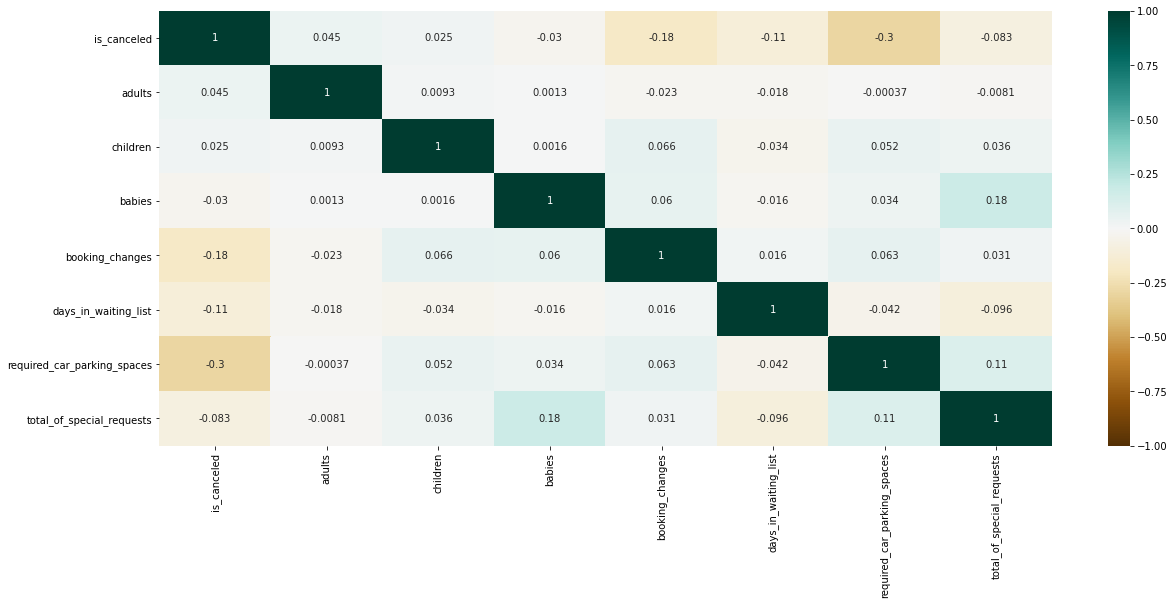

In [129]:
plt.figure(figsize=[20,8])
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

Korelasi data numeric, hasilnya tidak ada korelasi signifikan dengan feature is_canceled

In [139]:
data['is_canceled'].value_counts()/data.shape[0]*100

0    54.029194
1    45.970806
Name: is_canceled, dtype: float64

In [140]:
data['is_canceled'].value_counts()

0    2702
1    2299
Name: is_canceled, dtype: int64

* Sebanyak 54% pelanggan yang tidak cancel booking hotel.
* Terdapat 46% pelanggan yang cancel booking hotel

Cukup banyak yang Cancel kalo dilihat dari persentasenya

In [143]:
def plot_bar(column):
    #temp df
    temp_1 = pd.DataFrame()
    #count categorical values
    temp_1['No_Canceled'] = data[data['is_canceled']==0][column].value_counts()
    temp_1['Yes_Canceled'] = data[data['is_canceled']==1][column].value_counts()
    temp_1.plot(kind = 'bar')
    plt.xlabel(f'{column}')
    plt.ylabel ('Number of Customers')
    plt.title('Distribution of {} and Canceled'.format(column))
    plt.show()

In [144]:
# Data Categorical
col_obj = list(data.select_dtypes(['object']))
col_obj

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

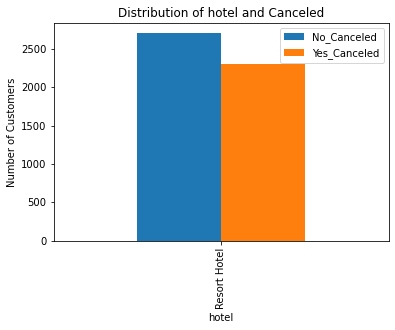

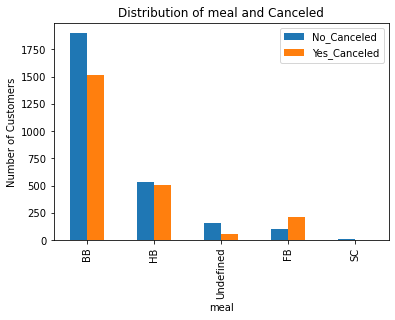

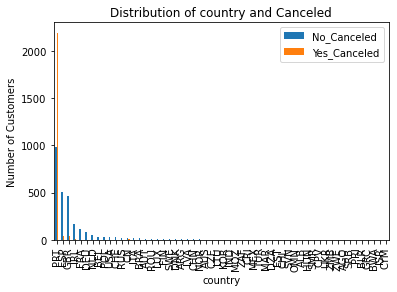

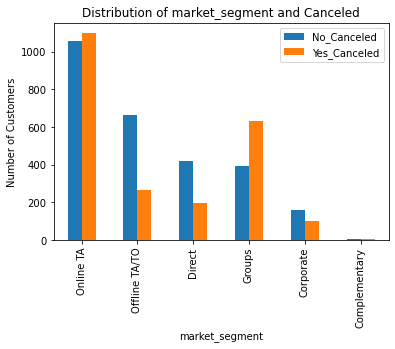

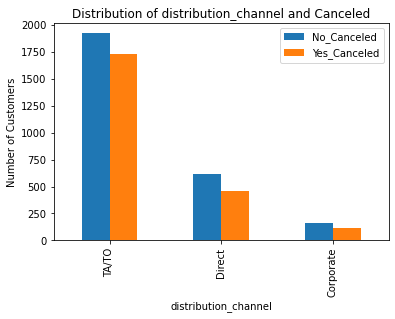

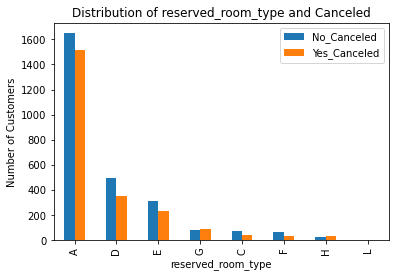

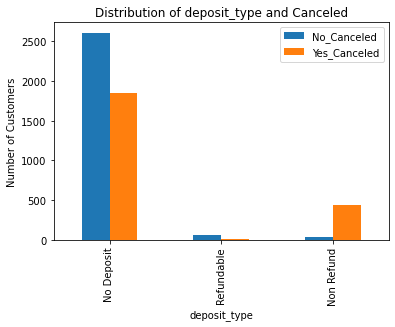

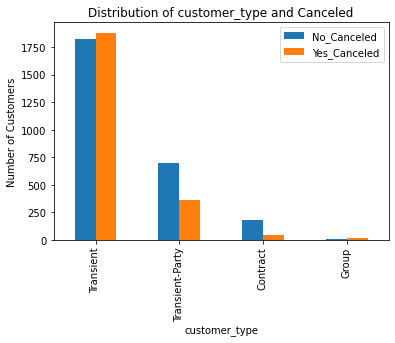

In [145]:
for i in col_obj:
    plot_bar(i)

In [46]:
def value(column):
    print('')
    print('No Canceled {}'.format(column))
    print(data[data['is_canceled']==0][column].value_counts())
    print('')
    print('Yes Canceled {}'.format(column))
    print(data[data['is_canceled']==1][column].value_counts())
for i in col_obj:
    value(i)


No Canceled hotel
Resort Hotel    2702
Name: hotel, dtype: int64

Yes Canceled hotel
Resort Hotel    2299
Name: hotel, dtype: int64

No Canceled meal
BB           1899
HB            529
Undefined     156
FB            105
SC             13
Name: meal, dtype: int64

Yes Canceled meal
BB           1519
HB            509
FB            214
Undefined      56
SC              1
Name: meal, dtype: int64

No Canceled country
PRT    985
ESP    506
GBR    467
IRL    167
FRA    111
DEU     86
NLD     55
BEL     29
POL     28
USA     28
CHE     26
RUS     23
CN      20
ITA     20
BRA     18
AUT     12
ROU     12
LUX     10
FIN      9
SWE      8
DNK      6
ARG      6
LVA      6
CHN      5
NOR      5
AUS      4
CZE      3
LTU      3
KOR      3
IND      3
MOZ      2
ZAF      2
CRI      2
MEX      2
TUR      2
MAR      2
DZA      2
EST      2
CHL      2
SVN      2
OMN      2
ALB      1
HUN      1
SMR      1
CPV      1
UKR      1
ZMB      1
ZWE      1
AGO      1
SRB      1
PRI      1
BLR      1
GRC    

Summary:
1. hotel x is_canceled
    - Dengan persentase 54% **Tidak Cancel** dan 46% **Cancel**.
2. Meal x is_canceled
    - Pada Meal BB
        - Terdapat persentase 55,5% **Tidak Cancel** dan 44,5% **Cancel**
    - Pada Meal HB
        - Terdapat persentase 51% **Tidak Cancel** dan 49% **Cancel**
    - Pada Meal FB
        - Terdapat persentase 33% **Tidak Cancel** dan 67% **Cancel**
    - Pada Meal SC
        - Terdapat persentase 93% **Tidak Cancel** dan 7% **Cancel**
    - Pada Meal Undefined
        - Terdapat persentase 73% **Tidak Cancel** dan 27% **Cancel**
3. Country x is_canceled
Terdapat 8 country yang cancel booking.
    - PRT dengan jumlah terbanyak sebesar 2190 dari 3175 order atau sekitar 68.9%.
4. Market Segment x is_canceled
    - Pada market online TA
        - Terdapat persentase 49% **Tidak Cancel** dan 51% **Cancel**
    - Pada market Groups
        - Terdapat persentase 38% **Tidak Cancel** dan 62% **Cancel** 
    - Pada market Offline TA/TO
        - Terdapat persentase 72% **Tidak Cancel** dan 28% **Cancel**
    - Pada market Direct
        - Terdapat persentase 68% **Tidak Cancel** dan 32% **Cancel**
    - Pada market Corporate
        - Terdapat persentase 61% **Tidak Cancel** dan 39% **Cancel**
    - Pada Market Complementary
        - Terdapat persentase 63% **Tidak Cancel** dan 37% **Cancel**
5. Distribution Channel x is_canceled
    - Pada distribution TA/TO
        - Terdapat persentase 53% **Tidak Cancel** dan 47% **Cancel**
    - Pada distribution Direct
        - Terdapat persentase 57% **Tidak Cancel** dan 43% **Cancel**
    - Pada distribution Corporate
        - Terdapat persentase 59% **Tidak Cancel** dan 41% **Cancel**
6. Reserved room type x is_canceled
    - Terdapat 3 tipe kamar yang relatif banyak digunakan
        - Room A, Terdapat persentase 52% **Tidak Cancel** dan 48% **Cancel**
        - Room D, Terdapat persentase 58% **Tidak Cancel** dan 42% **Cancel**
        - ROOM E, Terdapat persentase 57% **Tidak Cancel** dan 43% **Cancel**
7. Cancel Deposit x is_canceled
    - Pada No Deposit Type
        - Terdapat persentase 58% **Tidak Cancel** dan 42% **Cancel**
    - Pada Non Refund
        - Terdapat persentase 8% **Tidak Cancel** dan 92% **Cancel**
    - Pada Refundable
        - Terdapat persentase 87% **Tidak Cancel** dan 13% **Cancel**
8. Customer type x is_canceled
    - Pada Transient type
        - Terdapat persentase 49% **Tidak Cancel** dan 51% **Cancel**
    - Pada Transient Party
        - Terdapat persentase 66% **Tidak Cancel** dan 36% **Cancel**
    - Pada Contract
        - Terdapat persentase 80% **Tidak Cancel** dan 20% **Cancel**
    - Pada Group
        - Terdapat persentase 32% **Tidak Cancel** dan 68% **Cancel** 

In [123]:
#Data Numerical
col_num = list(data.select_dtypes(['int64','float64']).columns.drop('is_canceled'))
col_num

['adults',
 'children',
 'babies',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

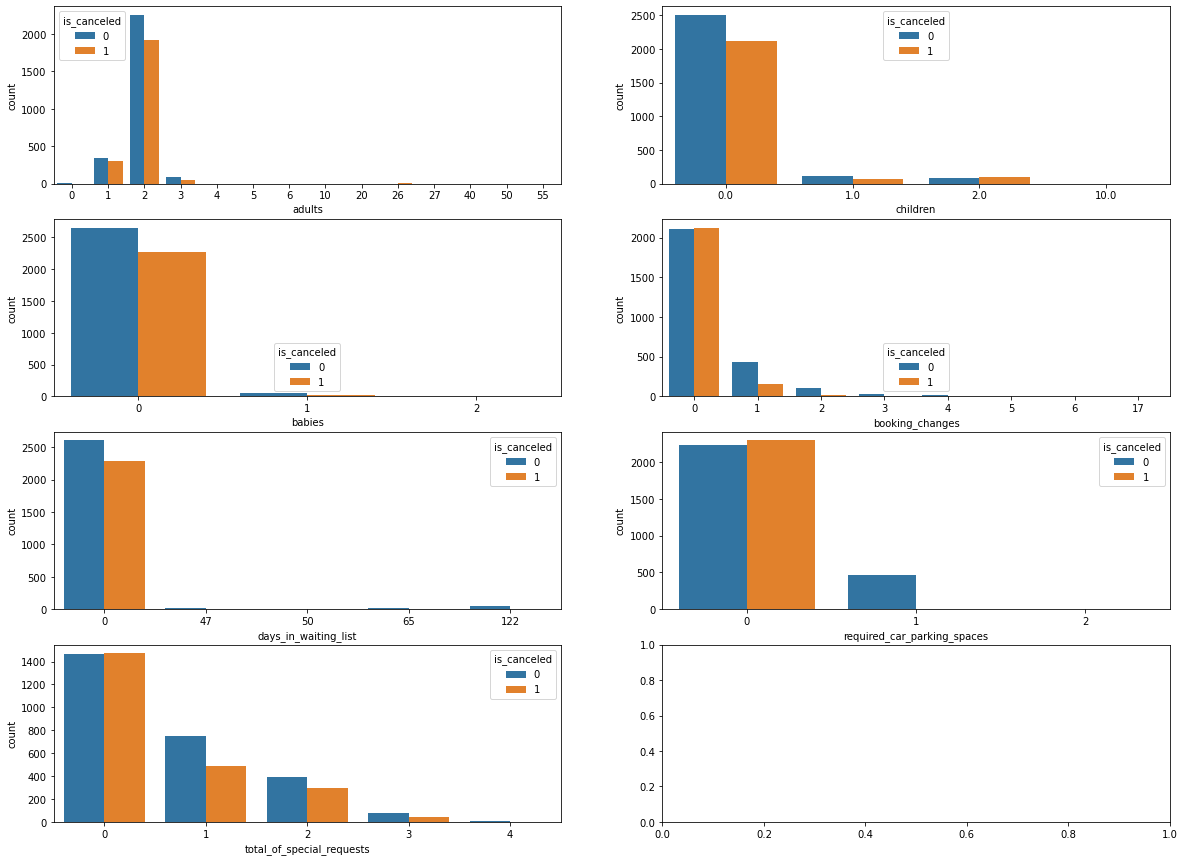

In [48]:
plt.figure(figsize=[20,15])
plt.subplot(421)
sns.countplot(x=data['adults'],hue=data['is_canceled'])
plt.subplot(422)
sns.countplot(x=data['children'],hue=data['is_canceled'])
plt.subplot(423)
sns.countplot(x=data['babies'],hue=data["is_canceled"])
plt.subplot(424)
sns.countplot(x=data['booking_changes'],hue=data['is_canceled'])
plt.subplot(425)
sns.countplot(x=data['days_in_waiting_list'],hue=data['is_canceled'])
plt.subplot(426)
sns.countplot(x=data['required_car_parking_spaces'],hue=data["is_canceled"])
plt.subplot(427)
sns.countplot(x=data['total_of_special_requests'],hue=data['is_canceled'])
plt.subplot(428)
plt.show()

In [148]:
def value(column):
    print('')
    print('No Canceled {}'.format(column))
    print(data[data['is_canceled']==0][column].value_counts())
    print('')
    print('Yes Canceled {}'.format(column))
    print(data[data['is_canceled']==1][column].value_counts())
for i in col_num:
    value(i)


No Canceled adults
2    2253
1     347
3      95
0       5
4       2
Name: adults, dtype: int64

Yes Canceled adults
2     1923
1      307
3       51
26       5
27       2
5        2
20       2
55       1
50       1
40       1
10       1
6        1
4        1
0        1
Name: adults, dtype: int64

No Canceled children
0.0    2505
1.0     109
2.0      88
Name: children, dtype: int64

Yes Canceled children
0.0     2121
2.0      106
1.0       71
10.0       1
Name: children, dtype: int64

No Canceled babies
0    2654
1      47
2       1
Name: babies, dtype: int64

Yes Canceled babies
0    2274
1      25
Name: babies, dtype: int64

No Canceled booking_changes
0     2116
1      429
2      107
3       27
4       16
5        4
6        2
17       1
Name: booking_changes, dtype: int64

Yes Canceled booking_changes
0    2127
1     153
2      13
3       4
4       2
Name: booking_changes, dtype: int64

No Canceled days_in_waiting_list
0      2609
122      52
47       21
65       19
50        1
Na

Summary
1. Adult x is_canceled
    - Terdapat kecenderungan cancel pada adult terbanyak pada nilai 2, 1, dan 3
2. Children x is_canceled
    - Tidak ada perbedaan signifikan dengan membawa children atau tidak 
3. Babies x is_canceled
    - Tidak ada perbedaan signifikan dengan membawa babies atau tidak 
4. Canceled booking_changes x is_canceled
    - Cancel booking hanya ada pada Canceled booking_changes 0, 1, 2, 3, 4. Namun tidak ada perbedaan signifikan.
5. days_in_waiting_list x is_canceled
    - cancel booking hanya ada pada days_in_waiting_list 0 dan 122.
6. equired_car_parking_spaces x is_canceled
    - cancel booking hanya ada pada yang tidak membutuhkan parking spaces.
7. total_of_special_requests x is_canceled
    - Tidak ada perbedaan signifikan antara cancel dan tidak cencel

# Data Cleaning and Preprocessing

#### Periksa Missing Value

In [116]:
data.isna().sum()

hotel                          0
is_canceled                    0
adults                         0
children                       0
babies                         0
meal                           0
country                        2
market_segment                 0
distribution_channel           0
reserved_room_type             0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

Missing Value:
- Country

#### Encoding Data

PreProcessing
- One Hot: hotel, meal, customer_type, deposit_type, distribution_channel,
- Binary: reserved_room_type, market_segment, country
- Passthrough: 'adults',
 'children',
 'babies',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests'

Saya memilih Binary encoding untuk data categorical lebih dari 5 dan OneHot untuk kurang dari 5.

In [118]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'most_frequent')),
                                    ('binary encoder',ce.BinaryEncoder()) #Memasukkan Missing Value dengan strategy most_frequent yaitu nilai modusnya
])
#cara kerja pipeline berurutan, jadi dimasukkan dulu nilai dari missing valuenya lalu encode binary

transformer = ColumnTransformer([
    ('one hot encoder',OneHotEncoder(drop = 'first'),['meal','hotel','customer_type','deposit_type','distribution_channel']),
    ('binary encoder',binary_encoder_pipeline,['reserved_room_type','market_segment','country'])
    ], remainder = 'passthrough')

# cara kerja dari columntransformer hanya mentransformerkan setiap kolom dengan cara berbeda dan secara paralel

# Splitting Data

In [80]:
X = data.drop('is_canceled', axis = 1) #Variabel Bebas
y = data['is_canceled'] #Target Data

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify = y, #Menyamakan rasio X dan Y
                                                   test_size = 0.3, #Pembagian test dan train
                                                   random_state = 2020)

# Model Benchmark & Evaluation Metric


* *0 = No Cancel*
* *1 = Yes Cancel*

        - TN: Ada Pelanggan yang di prediksi dengan No Cancel dan kenyataannya No Cancel
        - TP: Ada Pelanggan yang di prediksi dengan Yes Cancel dan kenyataannya Yes Cancel
        - FP: Ada Pelanggan yang di prediksi dengan Yes Cancel, padahal No Cancel
        - FN: Ada Pelanggan yang di prediksi dengan No Cancel padahal Yes Cancel

Atau pada Soal: 
- FP: Model memprediksi user akan cancel booking (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan.
- FN: Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user cancel booking (membatalkan pesanan).

Dalam konteks bisnis perhotelan, apabila pengunjung diasumsikan tidak cancel booking maka pihak hotel akan menyiapkan beberapa hal untuk menyambut kedatangan mereka, di antaranya:

- Menghubungi pengunjung terkait kapan perkiraan datang ke hotel,
- Membersihkan, merapikan, dan menyiapkan kamar sesuai pesanan pengunjung,
- Menyiapkan makanan dan minuman untuk menyambut kedatangan pengunjung,
- Menolak pengunjung lain yang memesan kamar yang telah dipesan (booked room), dan
- Memberi layanan penjemputan di bandara/stasiun/terminal apabila diperlukan.

Tindakan:
* FP: Salah prediksi, namun tidak dirugikan karna tetap akan ada pelanggan
* FN: Perusahaan rugi karena kehilangan Pelanggan, Menolak Pengunjung, dan biaya operasional lainnya.

- > Yang akan di tekan adalah FN, recall

In [89]:
def evaluate(df,model):

    model_name=[]
    recall_score=[]
    recall_std=[]
    for name, model in model:
        model = model
        estimator = Pipeline([
            ('preprocess', transformer),
            ('model', model)])

        skfold=StratifiedKFold(n_splits=5)
        score= cross_val_score(estimator,X_train,y_train,scoring='recall',cv=skfold).mean()
        std= cross_val_score(estimator,X_train,y_train,scoring='recall',cv=skfold).std()
        recall_score.append(score)
        recall_std.append(std)
        model_name.append(name)

    return pd.DataFrame({'Name': model_name,'recall_score':recall_score, 'recall_std':recall_std})

In [155]:
models = [
    ['Log Regression', LogisticRegression()],
    ['DecisionTree', DecisionTreeClassifier()],
    ['RandomForest', RandomForestClassifier()],
    ['KNeighbours', KNeighborsClassifier()]]

In [156]:
evaluate(df,models)

,Name,recall_score,recall_std
0,Log Regression,0.932254,0.015650
1,DecisionTree,0.870107,0.008630
2,RandomForest,0.893719,0.013232
3,KNeighbours,0.891852,0.006144


Karena recall score paling baik pada Log Regresi, maka saya pilih Log Regresi.

Regresi logistik adalah algoritma klasifikasi pembelajaran terbimbing yang digunakan untuk memprediksi probabilitas variabel target. Sifat target atau variabel dependen bersifat dikotomis, yang berarti hanya akan ada dua kelas yang memungkinkan.

Dengan kata sederhana, variabel dependen bersifat biner yang memiliki data dikodekan sebagai 1 (singkatan dari sukses / ya) atau 0 (singkatan dari kegagalan / tidak).

Secara matematis, model regresi logistik memprediksi P (Y = 1) sebagai fungsi X.

# Hyperparameter Tunning

In [149]:
model= LogisticRegression()
estimator= Pipeline([
    ('preprocessing', transformer),
    ('model',logreg)
])

In [150]:
hyperparam_space={
    'model__solver':['liblinear', 'newton-cg'],
    'model__C':[100,10,1,0.1,0.01,0.001]
}

In [151]:
skfold=StratifiedKFold(n_splits=5)
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='recall'
    ,n_jobs=-1
    )

In [152]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['meal',
                                                                          'hotel',
                                                                          'customer_type',
                                                                          'deposit_type',
                                                                          'distribution_c

In [153]:
print('best_score',grid_search.best_score_)
print('best_param',grid_search.best_params_)

best_score 0.9328747508755635
best_param {'model__C': 1, 'model__solver': 'liblinear'}


#### Setelah dilakukan hyperparameter tuning, tidak ada penambahan nilai yang signifikan.

- Before: 0.932254
- After: 0.932874

### Metode yang digunakan adalah LogisticRegression, scoring recall dengan parameter  model__C: 1 dan solver: liblinear

- Model C: nilai yang lebih kecil menentukan yang lebih kuat
- model solver: Algoritma yang akan digunakan dalam tuning